# Выпускной проект: телекоммуникации

# Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.


Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Цель данного проекта - дать клиенту систему, которая, на основе реальных данных пользователей опретора связи, будет прогнозировать отток клиентов, для возможности остановить клиента, предложив ему специальные условия.

Наша задача:
- загрузить данные, полученные от клиента;
- Изучить эти данные, возможно, при необходимости, их преобразовать;
- Выделить необходимые признаки;
- Определить модели;
- Подготовить данные, подходящие выбранным моделям;
- Провести моделирование на обучающей выборке;
- Проверить лучшую модель на тествой выборке;
- Провести анализ важности признаков модели
- Провести анализ матрицы ошибок лучшей модели
- Дать рекомендации для клиента.

Загрузим необходимые библиотеки

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
!pip install phik

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# work with text/strings
import re

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder, MinMaxScaler, OneHotEncoder
from phik import phik_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [4]:
RANDOM_STATE = 140823

Загрузим данные

In [5]:
try:
    contract_data = pd.read_csv('/datasets/contract_new.csv')
    personal_data = pd.read_csv('/datasets/personal_new.csv')
    internet_data = pd.read_csv('/datasets/internet_new.csv')
    phone_data = pd.read_csv('/datasets/phone_new.csv')
except:
    contract_data = pd.read_csv('contract_new.csv')
    personal_data = pd.read_csv('personal_new.csv')
    internet_data = pd.read_csv('internet_new.csv')
    phone_data = pd.read_csv('phone_new.csv')

Объединим данные в список

In [6]:
over_data = [contract_data, personal_data, internet_data, phone_data]

In [7]:
for data in over_data:
    print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 

Посмотрим инфу для каждой таблицы

In [8]:
for data in over_data:
    data.columns = data.columns.str.lower()

Преобразуем все значения в таблицах к нижнему регистру

In [9]:
def lowercase_columns(data):
    for column in data.columns:
        if data[column].dtype == 'object':
            data[column] = data[column].str.lower()
            data.columns = data.columns.str.lower()

In [10]:
for data in over_data:
    lowercase_columns(data)
    display(data.head())
    display(data.info())

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,31.04
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,2071.84
2,3668-qpybk,2019-10-01,no,month-to-month,yes,mailed check,53.85,226.17
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1960.6
4,9237-hqitu,2019-09-01,no,month-to-month,yes,electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerid,gender,seniorcitizen,partner,dependents
0,7590-vhveg,female,0,yes,no
1,5575-gnvde,male,0,no,no
2,3668-qpybk,male,0,no,no
3,7795-cfocw,male,0,no,no
4,9237-hqitu,female,0,no,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-vhveg,dsl,no,yes,no,no,no,no
1,5575-gnvde,dsl,yes,no,yes,no,no,no
2,3668-qpybk,dsl,yes,yes,no,no,no,no
3,7795-cfocw,dsl,yes,no,yes,yes,no,no
4,9237-hqitu,fiber optic,no,no,no,no,no,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerid,multiplelines
0,5575-gnvde,no
1,3668-qpybk,no
2,9237-hqitu,no
3,9305-cdskc,yes
4,1452-kiovk,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

сверим количество уникальных значений среди ID пользователей с количеством строк в таблицах

In [11]:
for data in over_data:
    display(data['customerid'].nunique())
    

7043

7043

5517

6361

количества совпадают. посмотрим на уникальные значения в столбце, с датой расторжения контракта

In [12]:
contract_data['enddate'].unique()

array(['no', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Загрузили 4 таблицы: contract_new.csv, personal_new.csv, internet_new.csv, phone_new.csv.
- contract_new.csv - информация о договоре
- personal_new.csv - персональные данные клиента
- internet_new.csv - информация об интернет-услугах
- phone_new.csv - информация об услугах телефонии


Данные таблицы не имеют пропусков, не имеют дубликатов по ID клиента. Все данные в таблицах, для удобства их обработки, мы превели к нижнему регистру.

В таблице с данными по заключенным контрактам, в поле даты окончания контракта есть значение 'no' - нужно будет его преобразовать в какую-то дату (подумаем пока в какую), что-бы понимать, что контракт не расторгнут.
Также, в этой таблице есть столбец totalcharges с типом object, хотя там лежит общая сумма потраченных денег на услуги - изменим тип на числовой.
Напрашивается изменить тип на дату у столбцов с датами начала и окончания действия контракта и добавить новый столбец с разницей этих дат - время действия контракта.

В таблице с персональными данными видим также ID клиента (все ID уникальные), видим, что часть признаков у нас бинарные, а часть категориальные (yes\no) - в последствии, при подготовке к моделированию - будем их кодировать в зависимости от выбранных моделей.

В таблицах с информацией об интернет-услугах и о телефонии пока не видим необходимости вносить какие-то изменения.
посмотрим распределения значений в таблицах на графиках

In [13]:
contract_data['totalcharges'] = pd.to_numeric(contract_data['totalcharges'], errors='coerce')
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [14]:
contract_data['begindate'] = pd.to_datetime(contract_data['begindate'])
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Чтобы изменить тип данных в столбце с датой окончания договора - заменим значения поля, где есть 'no' на '2020-02-01' - мы знаем, что информация о договорах актуально на 01-02-2020 а мы планировали получить данные о сроке действия контрактов. Но нам пока нужно это значение 'no', т.к. с его помощью мы можем определить является ли данный пользователь текущим клиентом или расторг договор в крайнюю дату (1 февраля 2020), поэтому для начала создадим новый столбец в таблице с контрактами - в котором проставим значения действующих договоров (yes 1 - если договор действующий, no 0 - если уже расторгнут, а потом только преобразуем.

In [15]:
contract_data['active'] = contract_data['enddate'].transform(lambda x: '1' if x == 'no' else '0')
contract_data.head(10)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,active
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,31.04,1
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,2071.84,1
2,3668-qpybk,2019-10-01,no,month-to-month,yes,mailed check,53.85,226.17,1
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1960.60,1
4,9237-hqitu,2019-09-01,no,month-to-month,yes,electronic check,70.70,353.50,1
5,9305-cdskc,2019-03-01,no,month-to-month,yes,electronic check,99.65,1150.96,1
6,1452-kiovk,2018-04-01,no,month-to-month,yes,credit card (automatic),89.10,2058.21,1
7,6713-okomc,2019-04-01,no,month-to-month,no,mailed check,29.75,300.48,1
8,7892-pookp,2017-07-01,no,month-to-month,yes,electronic check,104.80,3573.68,1
9,6388-tabgu,2014-12-01,2017-05-01,one year,no,bank transfer (automatic),56.15,1628.35,0


In [16]:
contract_data['enddate'] = contract_data['enddate'].transform(lambda x: '2020-02-01' if x == 'no' else x)
contract_data['enddate'] = pd.to_datetime(contract_data['enddate'])
contract_data.head(10)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,active
0,7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,1
1,5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,1
2,3668-qpybk,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,1
3,7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,1
4,9237-hqitu,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,1
5,9305-cdskc,2019-03-01,2020-02-01,month-to-month,yes,electronic check,99.65,1150.96,1
6,1452-kiovk,2018-04-01,2020-02-01,month-to-month,yes,credit card (automatic),89.10,2058.21,1
7,6713-okomc,2019-04-01,2020-02-01,month-to-month,no,mailed check,29.75,300.48,1
8,7892-pookp,2017-07-01,2020-02-01,month-to-month,yes,electronic check,104.80,3573.68,1
9,6388-tabgu,2014-12-01,2017-05-01,one year,no,bank transfer (automatic),56.15,1628.35,0


Добавим столбец с количеством дней действия контракта

In [17]:
contract_data['duration'] = contract_data['enddate'] - contract_data['begindate']
contract_data['duration'] = contract_data['duration'] / np.timedelta64(1,'D')
contract_data['duration'] = contract_data['duration'].astype('int64')
contract_data.head(10)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,active,duration
0,7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,1,31
1,5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,1,1036
2,3668-qpybk,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,1,123
3,7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,1,1371
4,9237-hqitu,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,1,153
5,9305-cdskc,2019-03-01,2020-02-01,month-to-month,yes,electronic check,99.65,1150.96,1,337
6,1452-kiovk,2018-04-01,2020-02-01,month-to-month,yes,credit card (automatic),89.10,2058.21,1,671
7,6713-okomc,2019-04-01,2020-02-01,month-to-month,no,mailed check,29.75,300.48,1,306
8,7892-pookp,2017-07-01,2020-02-01,month-to-month,yes,electronic check,104.80,3573.68,1,945
9,6388-tabgu,2014-12-01,2017-05-01,one year,no,bank transfer (automatic),56.15,1628.35,0,882


В последствии я думаю что столбец 'active' возьмем как целевой признак

построим графики распределения данных

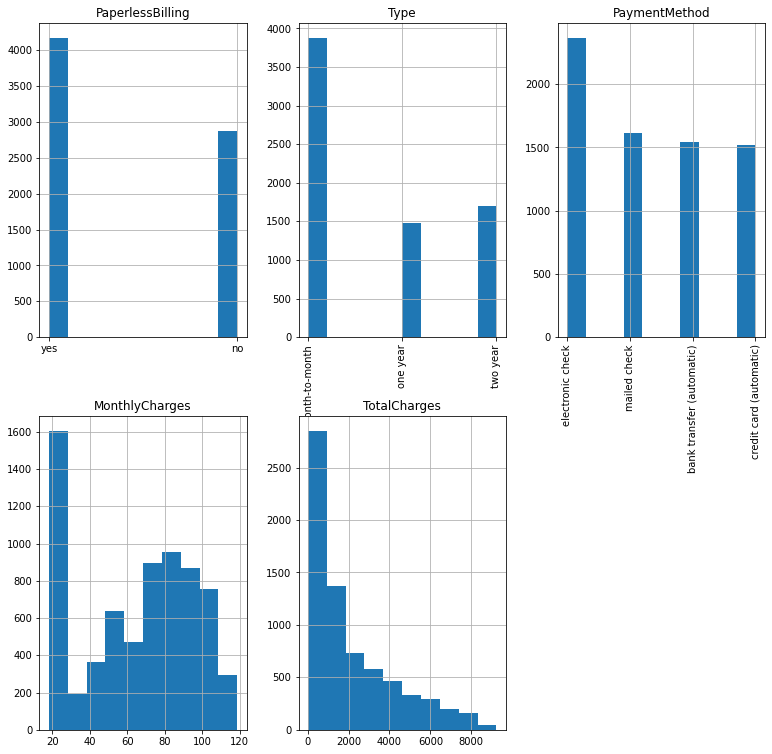

In [18]:
fig = plt.figure(figsize=(13, 13))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

fig.add_subplot(2, 3, 1)
plt.hist(contract_data['paperlessbilling'])
plt.grid()
plt.title('PaperlessBilling')

fig.add_subplot(2, 3, 2)
plt.hist(contract_data['type'])
plt.grid()
plt.title('Type')
plt.xticks(rotation=90)

fig.add_subplot(2, 3, 3)
plt.hist(contract_data['paymentmethod'])
plt.grid()
plt.title('PaymentMethod')
plt.xticks(rotation=90)

fig.add_subplot(2, 3, 4)
plt.hist(contract_data['monthlycharges'])
plt.grid()
plt.title('MonthlyCharges')

fig.add_subplot(2, 3, 5)
plt.hist(contract_data['totalcharges'])
plt.grid()
plt.title('TotalCharges')

plt.show()

По графикам можно заметить, что бОльшая часть клиентов предпочитает электронный платёжный документ, также большинство выбирают ежемесячную оплату. У большога числа клиентов ежемесячные траты по договору не привышают 30 у.е.(нигде в данных не увидела валюту, в которой заполнены данные по суммам). График общей суммы показывает, что примерно 1000 человек из общего объема клиентов потратили более 2500 у.е.на оплату услуг.
Рассмотрим график оттока клиентов

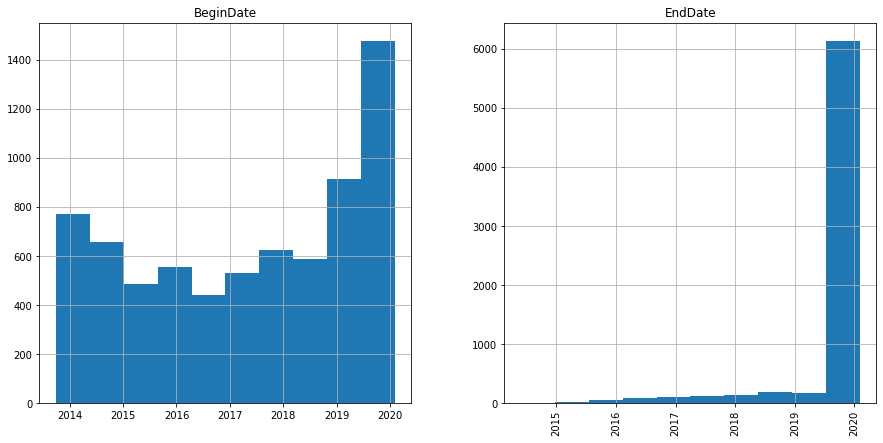

In [19]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

fig.add_subplot(1, 2, 1)
plt.hist(contract_data['begindate'])
plt.grid()
plt.title('BeginDate')

fig.add_subplot(1, 2, 2)
plt.hist(contract_data['enddate'])
plt.grid()
plt.xticks(rotation=90)
plt.title('EndDate')

plt.show()

Видим, что больше всего расторгнутых договоров (это видно на втором графике) у нас в 2020 - но это искусственное завышение, т.к.мы изменили значение даты расторжения договора на последнюю актуальную дату (2020г). в остальные года видим, что в период с начала 2015г до третьей декады 2015г и примерно со второй декады до конца 2016г был спад в оформлении договоров, далее, объемы заклученных договоров увеличивались, причем с 2018г до 2020г объемы увеличились более чем в 2 раза.
Что касается расторжения договоров - мы видим также растущий тренд, сравнивая кол-во пришедших и ушедших клиентов - можно сказать что период с 2016 по 2017гг были самые не удачные.

Посмотрим на распределения значений в таблице с персональными данными

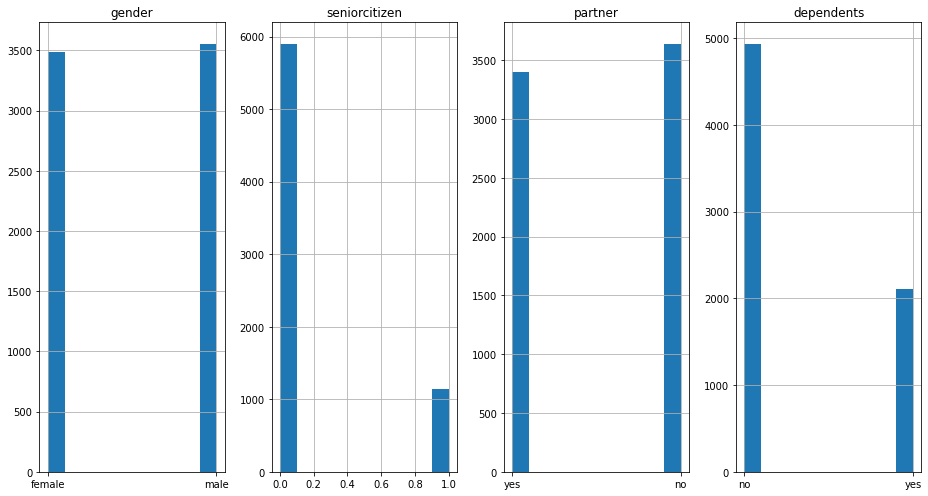

In [20]:
fig = plt.figure(figsize=(13, 7))
for i in range(1, 5):
    fig.add_subplot(1, 4, i)
    plt.hist(personal_data[personal_data.columns[i]])
    plt.grid()
    plt.title(personal_data.columns[i])
    plt.tight_layout()

Судя по графикам мы можем сказать, что у нас в базе примерно поровну клиентов мужского и женского пола, гораздо меньше пенсионеров и людей с иждивенцами. Клиенты, имеющие партнера, также, разделились примерно по-ровну.

Посомтрим на распределение значений в таблице с интернет-услугами

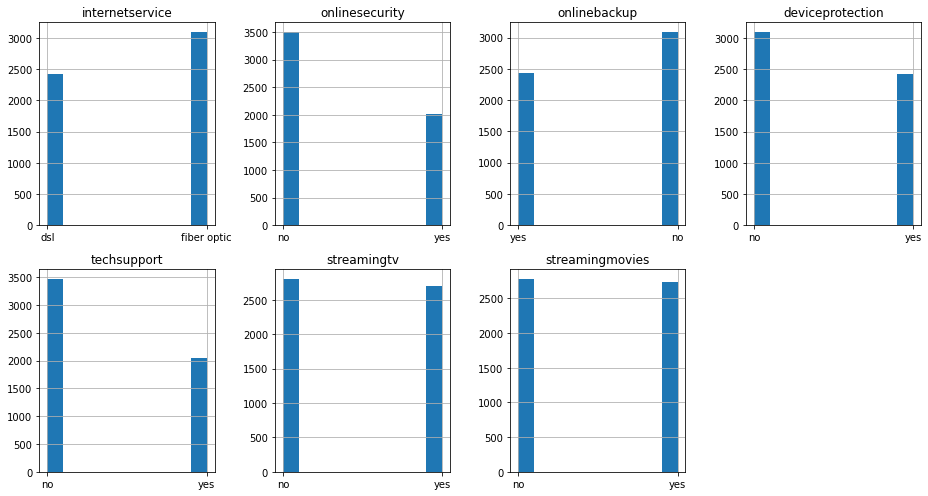

In [21]:
fig = plt.figure(figsize=(13, 7))
for i in range(1, 8):
    fig.add_subplot(2, 4, i)
    plt.hist(internet_data[internet_data.columns[i]])
    plt.grid()
    plt.title(internet_data.columns[i])
    plt.tight_layout()

Исходя из графиков, можно сделать вывод, что киентов, предпочетающих оптоволоконное соединение больше. Также больше и клиентов, которые принебрегают онлайн-защитой, не пользуются облачным хранилищем, не обращаются в техподдержку. Клиентов, которые пользуется стримминговыми сервисами по просмотру тв и видео примерно половина, из общего числа клиентов.

Осталось посмотреть, как рапределились значения в таблице, хранящей только одну услугу - это многоканальную линию

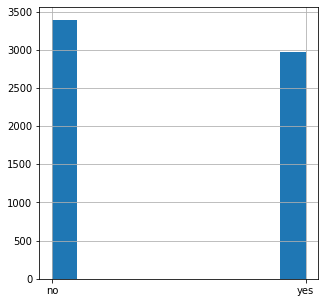

In [22]:
phone_data['multiplelines'].hist(figsize=(5, 5))
plt.show()

Видим, что у большинства клиентов эта услуга не подключена.

Промежуточный вывод: Мы загрузили 4 таблицы, посмотрели распределение данных в этих таблицах. В некторые таблицы дополнительно добавили новые столбцы, которые помогут нам в обучении моделей - добавили целевой признак (значение расторгнут ли договор, либо еще действующий).

Во многих столбцах встречаются категориальные значения, которые мы в будующем закодируем.

Прежде чем приступать к обучению моделей, нам понадобится объединить 4 таблицы в одну, провести анализ коллинеарности, чтобы оставить необходимые для обучения признаки, а лишние удалить.
Т.К. 4 таблицы у нас не объема, пр объединении появятся пустые поля - заполним эти поля (будем подбирать значения индивидуально, смотря где будут пропуски)
Разделим наши данные на 2 выборки с соотнощшением 3/1
Возьмем (простые для меня) модели логистической регрессии, случайного леса и градиентоного бустинга, в них будем подбирать гиперпараметри с помощью GridSearch и сравнивать их по метрике AUC-ROC, нам важно добиться значения больше 0,85
На тест возьмем лучшую модель и на ней уже посчитаем метрику Accuracy

Часть 2

Объединяем таблицы по customerid

In [23]:
big_data = contract_data.merge(personal_data, on='customerid', how='outer').merge(internet_data, on='customerid', how='outer').merge(phone_data, on='customerid', how='outer')

In [24]:
big_data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,active,duration,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,1,31,...,yes,no,dsl,no,yes,no,no,no,no,NaN
1,5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,1,1036,...,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-qpybk,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,1,123,...,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,1,1371,...,no,no,dsl,yes,no,yes,yes,no,no,NaN
4,9237-hqitu,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,1,153,...,no,no,fiber optic,no,no,no,no,no,no,no


смотрим наличие пропусков в данных

In [25]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   active            7043 non-null   object        
 9   duration          7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  seniorcitizen     7043 non-null   int64         
 12  partner           7043 non-null   object        
 13  dependents        7043 non-null   object        
 14  internetservice   5517 n

видим пропуски в столбце totalcharges (сумма потраченная на услуги - проверим дату подключения по договору, вероятно это новые абоненты),и в столбцах с доп услугами, таким как тех.поддержка, стримминговые сервисы, многоканальность - эти пропуски заменим на одинаковую заглушку 

In [26]:
filtered_big_data = big_data[big_data['totalcharges'].isnull()]
display(filtered_big_data)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,active,duration,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
488,4472-lvygi,2020-02-01,2020-02-01,two year,yes,bank transfer (automatic),52.55,NaN,1,0,...,yes,yes,dsl,yes,no,yes,yes,yes,no,NaN
753,3115-czmzd,2020-02-01,2020-02-01,two year,no,mailed check,20.25,NaN,1,0,...,no,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
936,5709-lvoeq,2020-02-01,2020-02-01,two year,no,mailed check,80.85,NaN,1,0,...,yes,yes,dsl,yes,yes,yes,no,yes,yes,no
1082,4367-nuyao,2020-02-01,2020-02-01,two year,no,mailed check,25.75,NaN,1,0,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
1340,1371-dwpaz,2020-02-01,2020-02-01,two year,no,credit card (automatic),56.05,NaN,1,0,...,yes,yes,dsl,yes,yes,yes,yes,yes,no,NaN
3331,7644-omvmy,2020-02-01,2020-02-01,two year,no,mailed check,19.85,NaN,1,0,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
3826,3213-vvolg,2020-02-01,2020-02-01,two year,no,mailed check,25.35,NaN,1,0,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
4380,2520-sgtta,2020-02-01,2020-02-01,two year,no,mailed check,20.00,NaN,1,0,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
5218,2923-arzlg,2020-02-01,2020-02-01,one year,yes,mailed check,19.70,NaN,1,0,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
6670,4075-wkniu,2020-02-01,2020-02-01,two year,no,mailed check,73.35,NaN,1,0,...,yes,yes,dsl,no,yes,yes,yes,yes,no,yes


Видим что действительно, 11 человек подптсали договор в последнюю актуальную дату полученой базы, поэтому заполним значения в столбце totalcharges медианными значениями, объем незаполненных значений не значительный, не думаю что это повлияет на работу моделей.

In [29]:
big_data['totalcharges'] = big_data['totalcharges'].fillna(0)

In [30]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   active            7043 non-null   object        
 9   duration          7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  seniorcitizen     7043 non-null   int64         
 12  partner           7043 non-null   object        
 13  dependents        7043 non-null   object        
 14  internetservice   5517 n

заполним пропуски в столбцах с услугами как "не используется" (not_used)

In [31]:
big_data = big_data.fillna('not_used')
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   active            7043 non-null   object        
 9   duration          7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  seniorcitizen     7043 non-null   int64         
 12  partner           7043 non-null   object        
 13  dependents        7043 non-null   object        
 14  internetservice   7043 n

Все пропуски заполнены, ни одного пользователя, при заполнении пропусков не потеряли.

далее, наша задача - отобрать (возможно создать новые) признаки для обучения наших моделей. Но для начала посмотрим на новое распределение данных

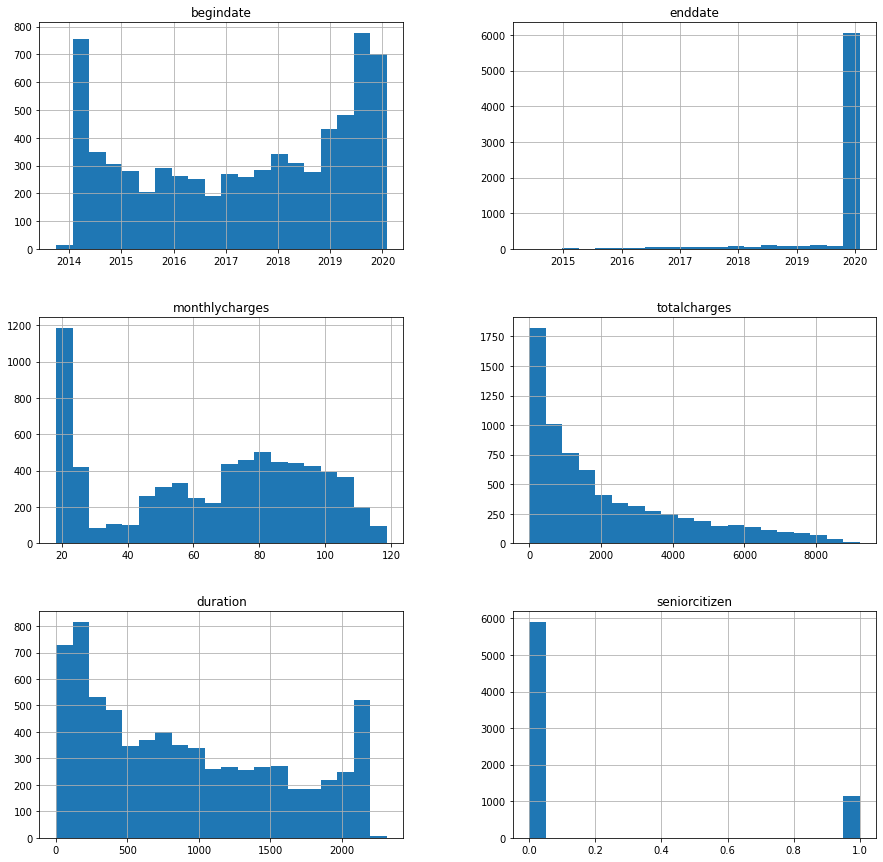

In [32]:
big_data.hist(figsize=(15,15), bins=20);

Видим выбросы в дате расторжения договора - мы помним что это созданный нами выброс, т.к.у действующих договоров нет даты расторжения. на графике продолжительности видим, что чем дольше клиент пользуетсяуслугами - тем реже он уходит, крайний правый пик - опять таки искусственный, созданный нами выброс.

In [33]:
columns = ['active','partner', 'gender', 'dependents','seniorcitizen','internetservice','onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies','multiplelines']

In [34]:
count_columns = len(columns)
count_str = (count_columns + 3) // 4

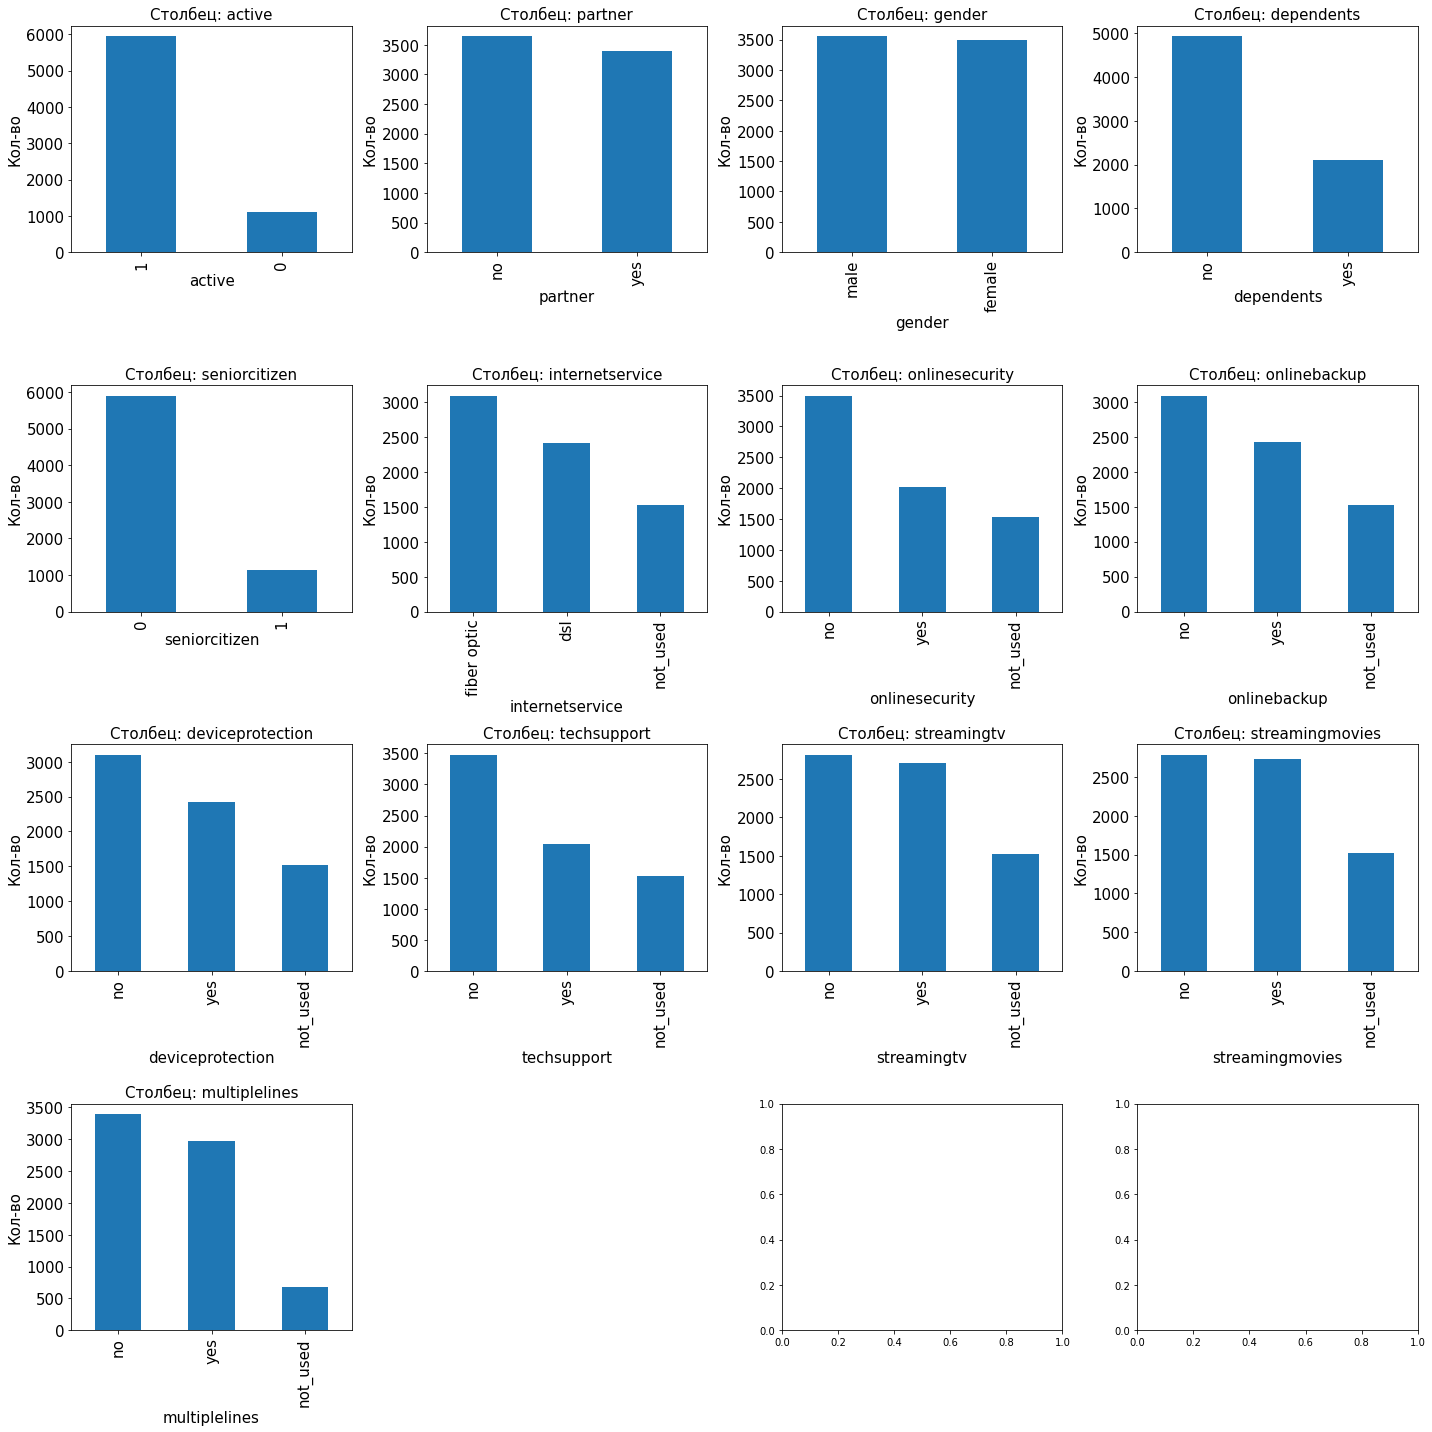

In [35]:
fig, axs = plt.subplots(count_str, 4, figsize=(20, 20))
for i, column in enumerate(columns):
    count = big_data[column].value_counts()
    ax = axs[i // 4, i % 4]
    count.plot(kind='bar', ax=ax, fontsize=15)
    ax.set_xlabel(column, fontsize=15)
    ax.set_ylabel('Кол-во', fontsize=15)
    ax.set_title(f'Столбец: {column}', fontsize=15)


if count_columns % 4 != 0:
    axs[count_str - 1, 1].remove()


plt.tight_layout()
plt.show()

после объединения таблиц, видим, что количество действующих договоров преобладает над количеством расторгнутых договоров. Пол распределился примерно одинаково, наличие партнера тоже отличается не сильно, график  иждевенцев показывает в большей степени отсутсвие иждевенцев, клиенты заказчика в основном не пенсионеры, которые пользуются больше оптоволокном, которые не используют онлайн-защиту, облачное хранилище, тех.поддержку и мультилинию. что касается использования стримминговых сервисов - тут количество тех кто пользуется и тех кто не пользуется - примерно одинаковое

Посмотрим на графики созданных нами признаков - актуальноси договора и продолжительности использования услуг по договору.

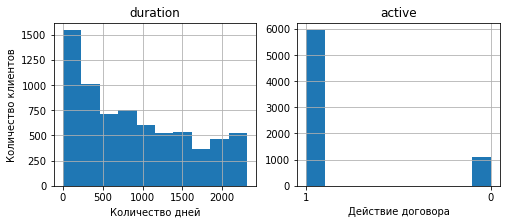

In [36]:
fig = plt.figure(figsize=(8, 3))

fig.add_subplot(1, 2, 1)
big_data['duration'].hist()
plt.title('duration')
plt.xlabel('Количество дней')
plt.ylabel('Количество клиентов')

fig.add_subplot(1, 2, 2)
big_data['active'].hist()
plt.title('active')
plt.xlabel('Действие договора')

plt.show()

на графике, отражающий количество действующих и прекращенных договор видим явный дисбаланс классов, который может дать большое количество ложноотрицательных ответов.

сделаем копию последней версии таблицы

In [38]:
copy_data = big_data.copy()

пока можем сказать, что столбцы с id клиента, с датой начала и датой окончания действия контраката нам точно не помогут в предсказании, удалим их

In [39]:
copy_data = copy_data.drop(columns=['customerid', 'begindate', 'enddate'])

In [43]:
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7043 non-null   object 
 1   paperlessbilling  7043 non-null   object 
 2   paymentmethod     7043 non-null   object 
 3   monthlycharges    7043 non-null   float64
 4   totalcharges      7043 non-null   float64
 5   active            7043 non-null   object 
 6   duration          7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   seniorcitizen     7043 non-null   int64  
 9   partner           7043 non-null   object 
 10  dependents        7043 non-null   object 
 11  internetservice   7043 non-null   object 
 12  onlinesecurity    7043 non-null   object 
 13  onlinebackup      7043 non-null   object 
 14  deviceprotection  7043 non-null   object 
 15  techsupport       7043 non-null   object 
 16  streamingtv       7043 non-null   object 


In [44]:
copy_data.head()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,active,duration,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,month-to-month,yes,electronic check,29.85,31.04,1,31,female,0,yes,no,dsl,no,yes,no,no,no,no,not_used
1,one year,no,mailed check,56.95,2071.84,1,1036,male,0,no,no,dsl,yes,no,yes,no,no,no,no
2,month-to-month,yes,mailed check,53.85,226.17,1,123,male,0,no,no,dsl,yes,yes,no,no,no,no,no
3,one year,no,bank transfer (automatic),42.30,1960.60,1,1371,male,0,no,no,dsl,yes,no,yes,yes,no,no,not_used
4,month-to-month,yes,electronic check,70.70,353.50,1,153,female,0,no,no,fiber optic,no,no,no,no,no,no,no


в interval_cols вношу числовые признаки

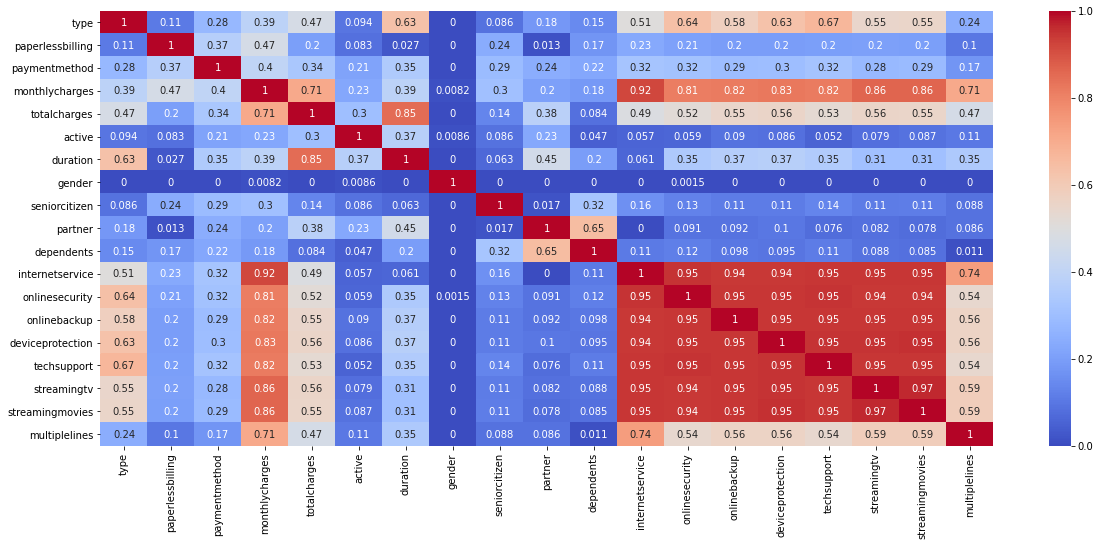

In [45]:
data_phik = phik_matrix(copy_data, interval_cols=['monthlycharges', 'totalcharges', 'duration'])
plt.figure(figsize=(20,8))
sns.heatmap(data_phik, annot=True, cmap='coolwarm')
plt.show()

с помощью матрицы, видим сильную зависимость подключенных услуг друг от друга, также видим влияние подключенных доп.услуг на размер ежемесячной оплаты (что логично), видим связь между доп.услугами и типом оплаты. Также видим, что значения продолжительности контракта коррелируют с типом оплаты, общей суммой оплаты, ежемесячными тратами, способами оплаты, с наличием партнера и актуальностью контракта, и примерно в равной друг от друга степени коррелирует с доп.услугами. 

In [47]:
copy_data['active'].astype(str).astype(int)

0       1
1       1
2       1
3       1
4       1
       ..
7038    1
7039    1
7040    1
7041    1
7042    1
Name: active, Length: 7043, dtype: int64

Перехожу непосредственно к делению выборок и потом кодирования признаков. для кодирования разбиваю на категориальные и числовые, далее выделяю целевой признак

In [49]:
numeric_features = ['monthlycharges', 'totalcharges', 'duration']
categorical_features = ['type',	'paperlessbilling',	'paymentmethod', 'gender', 'seniorcitizen', 'partner', 'dependents', 'internetservice',	'onlinesecurity', 'onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies','multiplelines']

делю в соотношении 3/1

In [50]:
y = copy_data['active']
X = copy_data.drop(['active'], axis=1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, train_size=0.75, random_state=RANDOM_STATE)

создаем трансформеры для признаков

In [52]:
numeric_transformer = StandardScaler()
categorical_transformer_rf_gb = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
categorical_transformer_lr = OneHotEncoder(handle_unknown='error', drop='first')

создаем ColumnTransformer для применения трансформеров к каждому типу признаков

In [53]:
preprocessor_rf_gb = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_rf_gb, categorical_features)
    ]
)

preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_lr, categorical_features)
    ]
)

создаем пайплайн для каждой модели

In [54]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor_lr), ('classifier', LogisticRegression(penalty='l2', random_state=RANDOM_STATE, class_weight='balanced'))])
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor_rf_gb), ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))])
pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor_rf_gb), ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))])

задаем гиперпараметры для каждой модели

In [55]:
param_grid_lr = {'classifier__C': [0.1, 1, 10]}
param_grid_rf = {'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [5, 10, 15]}
param_grid_gb = {'classifier__learning_rate': [0.1, 0.01, 0.001], 'classifier__n_estimators': [50, 100, 150]}

Создаем объекты GridSearchCV для каждой модели

In [56]:
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, scoring='roc_auc', cv=5)
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, scoring='roc_auc', cv=5)
grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, scoring='roc_auc', cv=5)

обучаем логистическую регрессию на обучающей выборке с помощью кроссвалидации

In [57]:
grid_search_lr.fit(X_train, y_train)
print("Логистическая регрессия:", grid_search_lr.best_params_, grid_search_lr.best_score_)


Логистическая регрессия: {'classifier__C': 1} 0.7586921351557072


обучаем случайный лес на обучающей выборке с помощью кроссвалидации и подбором наилучших параметров

In [58]:
grid_search_rf.fit(X_train, y_train)
print("Случайный лес:", grid_search_rf.best_params_, grid_search_rf.best_score_)

Случайный лес: {'classifier__max_depth': 10, 'classifier__n_estimators': 300} 0.8245791968249774


обучаем градиентный бустинг на обучающей выборке с помощью кроссвалидации и подбором наилучших параметров

In [59]:
grid_search_gb.fit(X_train, y_train)
print("Градиентный бустинг:", grid_search_gb.best_params_, grid_search_gb.best_score_)

Градиентный бустинг: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 150} 0.85769127509162


у меня получилось это не с первого раза, но я перешагнула рубеж в 0,85. берем модель градиентного бустинга, с гиперпараметрами classifier__learning_rate': 0.1, 'classifier__n_estimators': 150 для рассчета предсказаний на тестовую выборку. на тестовой выборке находим метрику auc-roc и accuracy

In [61]:
best_gb_model = grid_search_gb.best_estimator_
y_pred_gb = best_gb_model.predict_proba(X_test)[:, 1]
y_true = y_test.astype(int)
print("Метрики на тестовой выборке для градиентного бустинга с наилучшими гиперпараметрами:")
print("AUC-ROC:", roc_auc_score(y_test, y_pred_gb))
print("Accuracy:", accuracy_score(y_true, np.round(y_pred_gb)))

Метрики на тестовой выборке для градиентного бустинга с наилучшими гиперпараметрами:
AUC-ROC: 0.882677875559365
Accuracy: 0.8847245883021011


проинтерпретируем полученные результаты с точки зрения бизнеса.

AUC-ROC: Значение AUC-ROC равное 0.8827 говорит о том, что модель с высокой вероятностью правильно классифицирует случаи и генерирует более высокие вероятности для положительных классов по сравнению с отрицательными. Это означает, что модель обладает хорошей способностью различать между положительными и отрицательными случаями.

Accuracy: Значение точности (accuracy) равное 0.8847 указывает на то, что модель правильно классифицирует около 88.47% тестовых примеров. Это говорит о том, что модель в целом демонстрирует высокую точность в предсказании классов.

Общая интерпретация этих результатов для бизнеса состоит в том, что модель градиентного бустинга с наилучшими гиперпараметрами показывает хорошую способность различать между положительными и отрицательными случаями. Она также обладает высокой точностью в предсказании классов. Это может быть полезно во многих сценариях бизнеса, например, в задачах бинарной классификации, где важно точно определить положительные и отрицательные случаи, какой и является наша задача.

выведем матрицу ошибок наилучшей модели

In [62]:
confusion = confusion_matrix(y_true, np.round(y_pred_gb))

print("Матрица ошибок:")
print(confusion)

Матрица ошибок:
[[  87  182]
 [  21 1471]]


первое значение - количество правильно классифицированных отрицательных случаев, в нашей матрице это значение равно 87, это значит модель правильно предсказала 87 расторжений договора

второе значение - количество не правильно классифиццированных отрицательных случаев, в нашей матрице это значение равно 21, это означает, что модель пропустила 21 положительный случай (договор действителен) и отнесла их к группе расторгнутых договоров

третье значение - 182, и оно означает количество неправильно классифицированных положительных случаев. модель ошибочно отнесла 182 договора к действующим

четвертое значение - 1471, говорит о том, что модель правильно классифицировала 1471 положительный случай (договор действует)

In [63]:
feature_importances = best_gb_model.named_steps['classifier'].feature_importances_
sorted_importances = sorted(zip(feature_importances, categorical_features + numeric_features), reverse=True)
print("Оценка важности признаков:")
for importance, feature in sorted_importances:
    print(f"{feature}: {importance}")

Оценка важности признаков:
paymentmethod: 0.4565297762105712
gender: 0.1689709062697957
type: 0.11381993600686931
paperlessbilling: 0.10015183311009912
duration: 0.03804523700184296
onlinesecurity: 0.03185914153701189
partner: 0.03118769849905122
streamingmovies: 0.019180028613065593
streamingtv: 0.016111242242085818
techsupport: 0.0052029262789796615
onlinebackup: 0.00442079447442841
internetservice: 0.0035140138992956565
multiplelines: 0.0028808018243112092
seniorcitizen: 0.0026677768106399087
monthlycharges: 0.002646286935547117
totalcharges: 0.0014527563378627126
deviceprotection: 0.0009130819515306502
dependents: 0.0004457619970120304


Согласно оценке важности признаков видим, что набилее важные признаки для нашей модели градиентного бустинга являются:
- вид оплаты (0,457) - означает, что различные методы оплаты имеют существенное влияние на решение расторгнуть договор или остаться
- пол клиента (0,169) - влияет на решение уйти\остаться
- тип контркта (0,114) - скорее всего, клиенты с долгосрочными контрактами менее склонны к оттоку, по сравнению с клиентами, у которых краткосрочные контракты
- опция безбумажного биллинга (100) - также влияет на активность клиентов. Возможно клиенты, которые предпочитают электронные счета, более склонны оставаться активными
- длительность использования услуг (0,038) - оказывает влияние на активность клиентов. Клиенты, которые пользуются услугами компании уже длительное время, скорее всего, будут и дальше ими пользоваться.

Остальные признаки также вносят некоторый вклад в модель, но их важность относительно ниже.

Эти результаты позволяют нам лучше понять, какие факторы оказывают наибольшее влияние на активность клиентов и могут помочь в принятии более обоснованных решений в области управления клиентами и предотвращении оттока.



# Отчет

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
- За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание данных.
Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.
- Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Цель данного проекта - дать клиенту систему, которая, на основе реальных данных пользователей опретора связи, будет прогнозировать отток клиентов, для возможности остановить клиента, предложив ему специальные условия.

### Ключевые шаги работы над проектом:

- Загрузить данные, полученные от клиента

- Изучить эти данные,при необходимости - преобразовали;

- Выделеть необходимые признаки;

- Определиться с моделями;

- Подготовить данные, подходящие выбранным моделям ;

- Провести моделирование на обучающей выборке;

- Проверить лучшую модель на тествой выборке;

- Провести анализ важности признаков модели

- Провести анализ матрицы ошибок лучшей модели



### Анализ соответствия фактической работы запланированным шагам:

Фактическая работа проводилась в соответсвии с написанным планом, за исключением дополнительного анализа данных,который потребовался после сведения нескольких таблиц, полученных от заказчика, в одну общую таблицу

### Рефлексия над сложностями и описание путей их решения:

- Сложность в интерпретировании данных, особенно в переводе полученных результатов на язык бизнеса. Пришлось додумывать кому мы "сдаем проект" и что ему на самом деле полезно слышать
- Пробел в кодировании и масштабировании, в необходимости устранения дисбаланса
- Сложности интерпретации значений у полученных метрик и опять таки их перевод на язык бизнеса
- Не понимание установленного порога на метрики - кто их на самом деле устанавливает и какой должен быть критерий для этого порога 

### Итоговый список признаков для обучения модели, способы их обработки:

Для обучения моделей, кроме целевого признака (active) мы оставили признаки, перечисленные ниже:

- PaymentMethod - Способ оплаты
- Gender - Пол
- Type - тип оплаты: ежемесячный, годовой и т.д.
- PaperlessBilling - электронный платёжны документ
- Duration - созданный признак - продолжительность действия договора (с момента его заключения до момента его расторжения)
- OnlineSecurity - Онлайн-безопасность
- Partner - наличие партнера
- StreamingMovies - сервис просмотра фильмов онлайн
- StreamingTV - сервис просмотра ТВ онлайн
- TechSupport - услуга технической поддержки
- OnlineBackup - облачное хранилище
- InternetService - интернет-провайдер клиента (DSL, Fiber optic, No)
- Multiplelines - наличие многоканальной линии
- SeniorCitizen - наличие статуса пенсионера
- MonthlyCharges - месячный размер оплат по услугам
- TotalCharges - общая сумма оплат за все время
- DeviceProtection - наличие или отсутствие страховки оборудования
- Dependents - наличие иждевенцев

Часть признаков была числовыми, а часть категориальными. Числовые признаки стандартизировали с помощью StandardScaler. Для категориальных - воспользовались двумя кодировщиками - OrdinalEncoder для модели случайного леса и градиентного бустинга, и OneHotEncoder для модели логистической регрессии. На этапе анализа корреляции признаков была выявлена мультиколлинеарность, которую устраняли с помощью L2 регуляризации

### Краткое описание предобработки данных:

- загрузили осмотрели данные в 4х таблицах
- исследовали на наличие пропусков - не выявили
- преобразовали все символы в таблицах к нижнему регистру
- преобразовали некторые признакы к другим типам данных (например дата заключения и расторжения договоров)
- обратили внимание на значение "no" в столбце с датой расторжения договора - заменили данное значение на дату выгрузки данных, с помощью этого заполнения смогли высчитать и добавить новые признаки - длительность договора и актуальности действия договора
- Объединили таблицы и обнаружили пропуски в некоторых полях. пропуски в поле с общей суммой внесенных платежей заполнили нулями (т.к. проверили что клиенты заключили договор в день выгрузки данных и еще не успели ничего оплатить), а пропуски в других полях заполнили заглушкой "not_used" для маркировки услуг, которые вообще не использовались абонентом
- исследовали графики, на которых обнаружили что пол и наличие и отсутствие партнера находятся примерно в равном распределении, а вот количество действующих договоров намного превышает количество расторгнутых (которое указало на дисбаланс классов)
- изучили график корреляции, на котором выявили мультиколлинеарность, которую устраняли для линейной модели с помощью L2 регуляризации
- разбили на выборки
- закодировали данные - для этого разделили кодирование данных для линейной модели и данных для случайного леса и градиентного бустинга

### Сводная таблица исследованных моделей и их метрика на кросс-валидации

In [64]:
results = pd.DataFrame(columns=['Модель', 'Лучшие параметры', 'Лучшая метрика'])

In [65]:
lr_best_params = grid_search_lr.best_params_
lr_best_score = grid_search_lr.best_score_
results.loc[0] = ['Логистическая регрессия', lr_best_params, lr_best_score]
display(results)

,Модель,Лучшие параметры,Лучшая метрика
0,Логистическая регрессия,{'classifier__C': 1},0.758692


In [66]:
rf_best_params = grid_search_rf.best_params_
rf_best_score = grid_search_rf.best_score_
pd.set_option('display.max_colwidth', None)
results.loc[1] = ['Случайный лес', rf_best_params, rf_best_score]
display(results)

,Модель,Лучшие параметры,Лучшая метрика
0,Логистическая регрессия,{'classifier__C': 1},0.758692
1,Случайный лес,"{'classifier__max_depth': 10, 'classifier__n_estimators': 300}",0.824579


In [67]:
gb_best_params = grid_search_gb.best_params_
gb_best_score = grid_search_gb.best_score_
pd.set_option('display.max_colwidth', None)
results.loc[2] = ['Градиентный бустинг', gb_best_params, gb_best_score]
display(results)

,Модель,Лучшие параметры,Лучшая метрика
0,Логистическая регрессия,{'classifier__C': 1},0.758692
1,Случайный лес,"{'classifier__max_depth': 10, 'classifier__n_estimators': 300}",0.824579
2,Градиентный бустинг,"{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 150}",0.857691


### Лучшая модель на кросс-валидации

In [68]:
best_model = results.loc[results['Лучшая метрика'].idxmax()]
best_model_name = best_model['Модель']
best_model_params = best_model['Лучшие параметры']
best_score = best_model['Лучшая метрика']
print(f"Лучшая модель по AUC-ROC: {best_model_name}")
print(f"Значение AUC-ROC: {best_score}")
print("Гиперпараметры лучшей модели:")
print(best_model_params)

Лучшая модель по AUC-ROC: Градиентный бустинг
Значение AUC-ROC: 0.85769127509162
Гиперпараметры лучшей модели:
{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 150}


### Итоговая метрика на test 

In [69]:
test_model = {
    'Model': ['Градиентный Бустинг'],
    'AUC-ROC': [roc_auc_score(y_test, y_pred_gb)],
    'Accuracy': [accuracy_score(y_true, np.round(y_pred_gb))],
    'Гиперпараметры': [best_model_params]
}


best_test_model = pd.DataFrame(test_model)
pd.set_option('display.max_colwidth', None)
best_test_model

,Model,AUC-ROC,Accuracy,Гиперпараметры
0,Градиентный Бустинг,0.882678,0.884725,"{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 150}"


проинтерпретируем полученные результаты с точки зрения бизнеса.

AUC-ROC: Значение AUC-ROC равное 0.8827 говорит о том, что модель с высокой вероятностью правильно классифицирует случаи и генерирует более высокие вероятности для положительных классов по сравнению с отрицательными. Это означает, что модель обладает хорошей способностью различать между положительными и отрицательными случаями.

Accuracy: Значение точности (accuracy) равное 0.8847 указывает на то, что модель правильно классифицирует около 88.47% тестовых примеров. Это говорит о том, что модель в целом демонстрирует высокую точность в предсказании классов.

Общая интерпретация этих результатов для бизнеса состоит в том, что модель градиентного бустинга с наилучшими гиперпараметрами показывает хорошую способность различать между положительными и отрицательными случаями. Она также обладает высокой точностью в предсказании классов. Это может быть полезно во многих сценариях бизнеса, например, в задачах бинарной классификации, где важно точно определить положительные и отрицательные случаи, какой и является наша задача.

### Матрица ошибок

In [70]:
confusion = confusion_matrix(y_true, np.round(y_pred_gb))

print("Матрица ошибок:")
print(confusion)

Матрица ошибок:
[[  87  182]
 [  21 1471]]


Интерпретация матрицы ошибок: 

первое значение - количество правильно классифицированных отрицательных случаев, в нашей матрице это значение равно 87, это значит модель правильно предсказала 87 расторжений договора

второе значение - количество не правильно классифиццированных отрицательных случаев, в нашей матрице это значение равно 21, это означает, что модель пропустила 21 положительный случай (договор действителен) и отнесла их к группе расторгнутых договоров

третье значение - 182, и оно означает количество неправильно классифицированных положительных случаев. модель ошибочно отнесла 182 договора к действующим

четвертое значение - 1471, говорит о том, что модель правильно классифицировала 1471 положительный случай (договор действует)

### Важность признаков

In [71]:
feature_importances = best_gb_model.named_steps['classifier'].feature_importances_
sorted_importances = sorted(zip(feature_importances, categorical_features + numeric_features), reverse=True)
print("Оценка важности признаков:")
for importance, feature in sorted_importances:
    print(f"{feature}: {importance}")

Оценка важности признаков:
paymentmethod: 0.4565297762105712
gender: 0.1689709062697957
type: 0.11381993600686931
paperlessbilling: 0.10015183311009912
duration: 0.03804523700184296
onlinesecurity: 0.03185914153701189
partner: 0.03118769849905122
streamingmovies: 0.019180028613065593
streamingtv: 0.016111242242085818
techsupport: 0.0052029262789796615
onlinebackup: 0.00442079447442841
internetservice: 0.0035140138992956565
multiplelines: 0.0028808018243112092
seniorcitizen: 0.0026677768106399087
monthlycharges: 0.002646286935547117
totalcharges: 0.0014527563378627126
deviceprotection: 0.0009130819515306502
dependents: 0.0004457619970120304


In [72]:
feature_importances = best_gb_model.named_steps['classifier'].feature_importances_
features = categorical_features + numeric_features
sorted_importances = sorted(zip(feature_importances, features), reverse=True)
importances = [imp for imp, _ in sorted_importances]
labels = [feat for _, feat in sorted_importances]

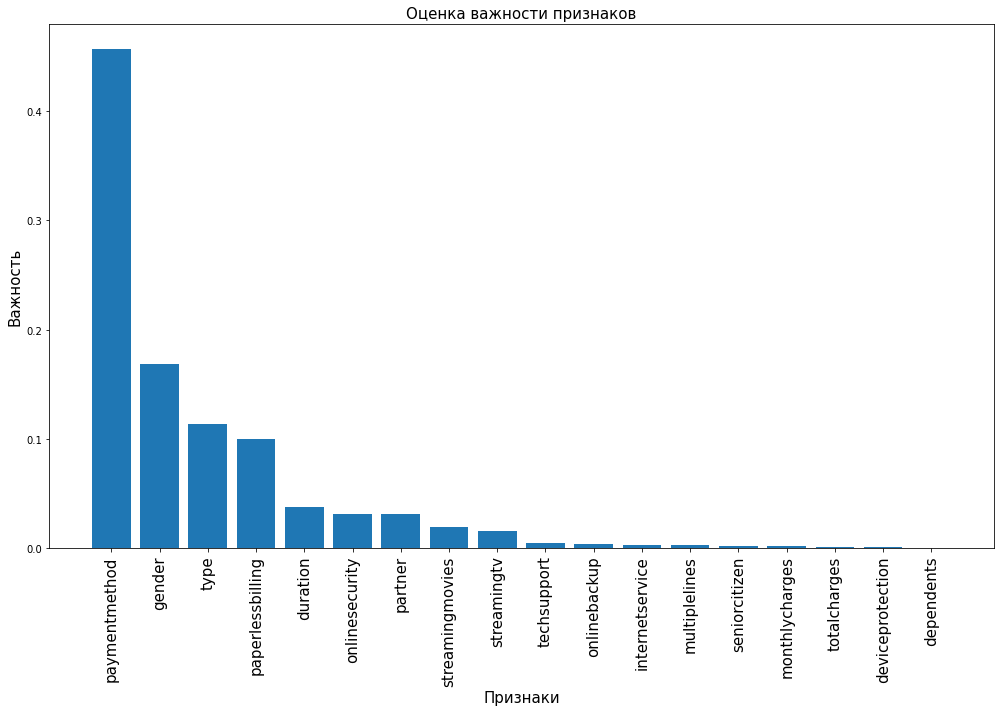

In [73]:
plt.figure(figsize=(14, 10))
plt.bar(range(len(importances)), importances, align='center')
plt.xticks(range(len(importances)), labels, rotation='vertical', fontsize=15)
plt.xlabel('Признаки', fontsize=15)
plt.ylabel('Важность', fontsize=15)
plt.title('Оценка важности признаков', fontsize=15)
plt.tight_layout()
plt.show()

Согласно оценке важности признаков видим, что набилее важные признаки для нашей модели градиентного бустинга являются:

вид оплаты (0,457) - означает, что различные методы оплаты имеют существенное влияние на решение расторгнуть договор или остаться

пол клиента (0,169) - влияет на решение уйти\остаться

тип контркта (0,114) - скорее всего, клиенты с долгосрочными контрактами менее склонны к оттоку, по сравнению с клиентами, у которых краткосрочные контракты

опция безбумажного биллинга (100) - также влияет на активность клиентов. Возможно клиенты, которые предпочитают электронные счета, более склонны оставаться активными

длительность использования услуг (0,038) - оказывает влияние на активность клиентов. Клиенты, которые пользуются услугами компании уже длительное время, скорее всего, будут и дальше ими пользоваться.

Остальные признаки также вносят некоторый вклад в модель, но их важность относительно ниже.

Эти результаты позволяют нам лучше понять, какие факторы оказывают наибольшее влияние на активность клиентов и могут помочь в принятии более обоснованных решений в области управления клиентами и предотвращении оттока.